# TweetEmotionRecognition
Exploration of the data, preprocessing and creation, training and evaluation of the model.

Dataset used: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

In [ ]:
!pip install nlp==0.4.0

### Setup and imports

In [2]:
%matplotlib inline

import nlp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Importing Data

In [ ]:
dataset = nlp.load_dataset('emotion')

The dataset imported contains test, train and validation

In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
test = dataset['test']
train = dataset['train']
validation = dataset['validation']

In [6]:
test

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)

In [7]:
tweets_test = [x['text'] for x in test]
labels_test = [x['label'] for x in test]

tweets_train = [x['text'] for x in train]
labels_train = [x['label'] for x in train]

tweets_val = [x['text'] for x in validation]
labels_val = [x['label'] for x in validation]

Number of examples

In [8]:
print('Train examples: {} \nTest examples: {} \nValidation examples: {}'.format(len(tweets_train), len(tweets_test), len(tweets_val)))

Train examples: 16000 
Test examples: 2000 
Validation examples: 2000


Some examples of the data

In [9]:
for i in range(5):
  print('Tweet: {} \nEmotion: {}\n'.format(tweets_test[i], labels_test[i]))

Tweet: im feeling rather rotten so im not very ambitious right now 
Emotion: sadness

Tweet: im updating my blog because i feel shitty 
Emotion: sadness

Tweet: i never make her separate from me because i don t ever want her to feel like i m ashamed with her 
Emotion: sadness

Tweet: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived 
Emotion: joy

Tweet: i was feeling a little vain when i did this one 
Emotion: sadness



### Tokenizer

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

token = Tokenizer(num_words = 10000, oov_token= '<UNK>')

In [11]:
token.fit_on_texts(tweets_train)

### A bit data exploration

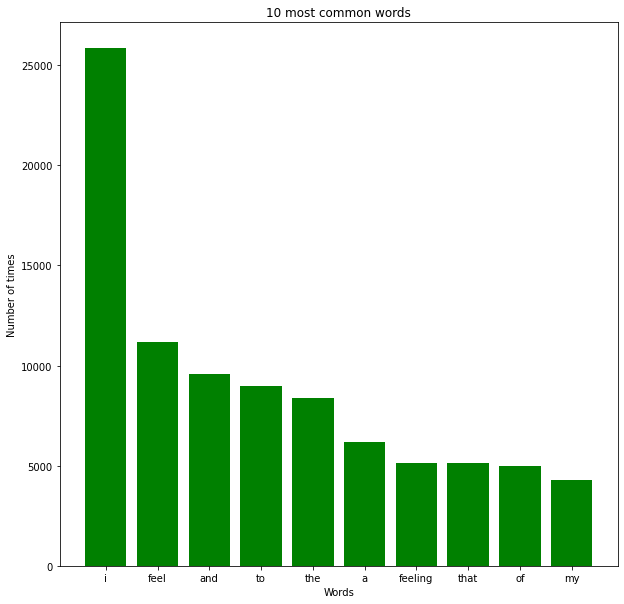

Total words: 306661


In [12]:
plt.rcParams["figure.figsize"] = (10,10)

from collections import Counter

words = [x.split(' ') for x in tweets_train]
words_num = sum([len(l) for l in words])
counter = Counter(words[0])
for i in words[1:]: 
    counter.update(i)

common_words = counter.most_common(10)
nwords = [w for w, q in common_words]
qwords = [q for w, q in common_words]

plt.bar(nwords, qwords, color='green')
plt.ylabel('Number of times')
plt.xlabel('Words')
plt.title('10 most common words')
plt.show()
print('Total words: {}'.format(words_num))

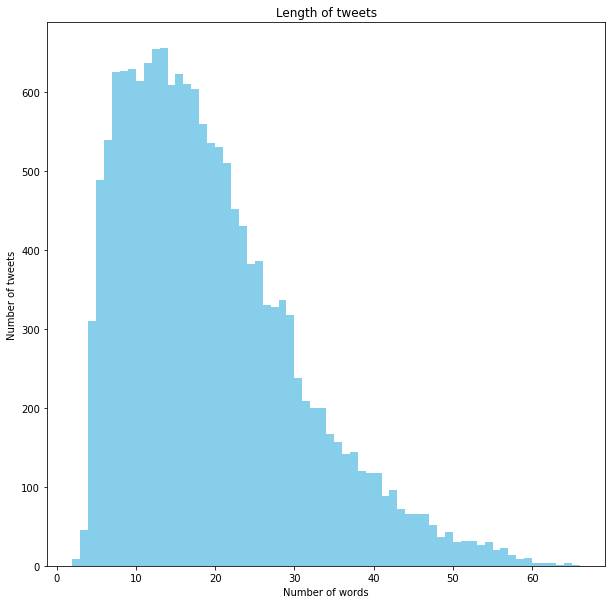

Average length of a tweet: 19.1663125
Mode: 13
Median: 17.0
Standard deviation: 10.986561229627027


In [13]:
import statistics

tweet_lenght = [len(x.split(' ')) for x in tweets_train]
plt.hist(tweet_lenght, bins= len(set(tweet_lenght)), color='skyblue')
plt.ylabel('Number of tweets')
plt.xlabel('Number of words')
plt.title('Length of tweets')
plt.show()
print('Average length of a tweet: {}'.format(statistics.mean([len(x.split(' ')) for x in tweets_train])))
print('Mode: {}'.format(statistics.mode([len(x.split(' ')) for x in tweets_train])))
print('Median: {}'.format(statistics.median([len(x.split(' ')) for x in tweets_train])))
print('Standard deviation: {}'.format(statistics.pstdev([len(x.split(' ')) for x in tweets_train])))

We are facing an imbalanced classes problem

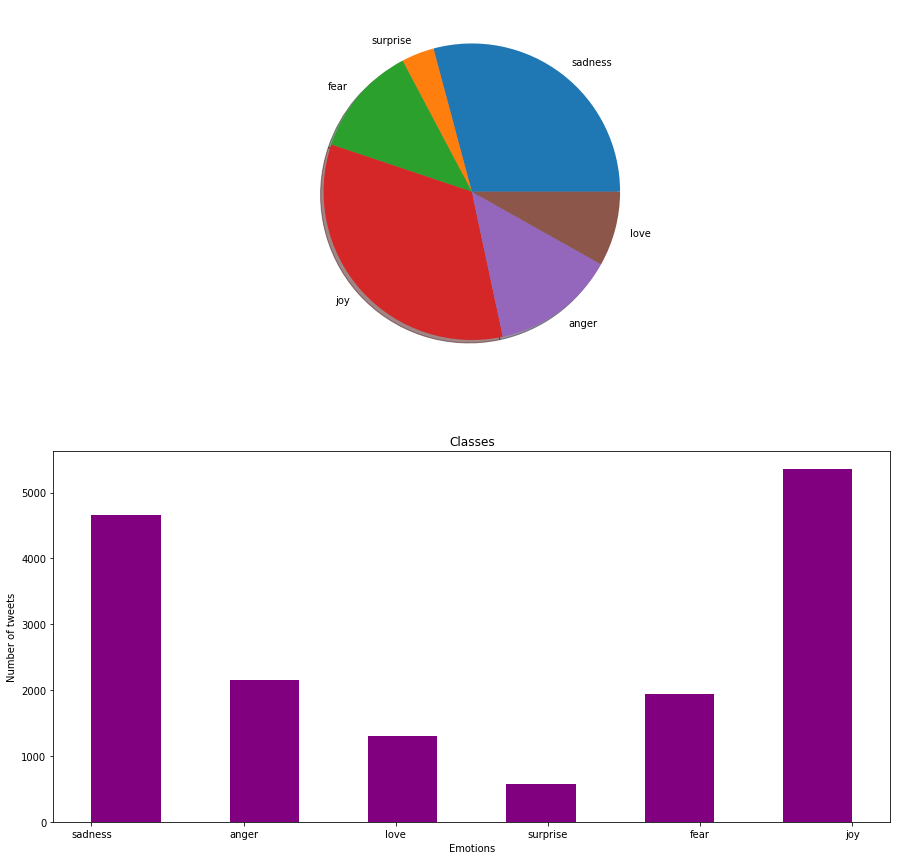

In [14]:
plt.rcParams["figure.figsize"] = (15, 15)

tags = set(labels_train)
pie_cont = [labels_train.count(i) for i in tags]

plt.subplot(211)
plt.pie(pie_cont, labels= tags, shadow= True)

plt.subplot(212)
plt.hist(labels_train, color='purple', bins = 11)
plt.ylabel('Number of tweets')
plt.xlabel('Emotions')
plt.title('Classes')
plt.show()



plt.show()

### Padding, Truncating Sequences and preparing labels

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen  = 50

In [16]:
test_seq = token.texts_to_sequences(tweets_test)
train_seq = token.texts_to_sequences(tweets_train)
val_sq = token.texts_to_sequences(tweets_val)

In [17]:
test_padded = pad_sequences(sequences= test_seq, maxlen= maxlen, padding= 'post', truncating= 'post')
train_padded = pad_sequences(sequences= train_seq, maxlen= maxlen, padding= 'post', truncating= 'post')
val_padded = pad_sequences(sequences= val_sq, maxlen= maxlen, padding= 'post', truncating= 'post')

print('Before : {} \n After: {}'.format(tweets_test[0], test_padded[0]))

Before : im feeling rather rotten so im not very ambitious right now 
 After: [  17    8  203  715   15   17   26   46 5595  114   58    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [18]:
classes = set(labels_train)

classes_to_index = dict((c, i) for i, c in enumerate(classes))
print(classes_to_index)

{'sadness': 0, 'surprise': 1, 'fear': 2, 'joy': 3, 'anger': 4, 'love': 5}


In [19]:
index_to_classes = dict((i, c) for c, i in classes_to_index.items())
print(index_to_classes)

{0: 'sadness', 1: 'surprise', 2: 'fear', 3: 'joy', 4: 'anger', 5: 'love'}


In [20]:
label_ind = lambda label: np.array([classes_to_index.get(l) for l in label]) 

In [21]:
lab_ind_test = label_ind(labels_test)
lab_ind_train = label_ind(labels_train)
lab_ind_val = label_ind(labels_val)

print('Tweet: {} \nLabel: {} \nIndex: {}'.format(tweets_test[0], labels_test[0], lab_ind_test[0]))

Tweet: im feeling rather rotten so im not very ambitious right now 
Label: sadness 
Index: 0


###Creating the Model

In [22]:
Emodel = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation= "softmax")
])

In [23]:
Emodel.compile(
    loss= 'sparse_categorical_crossentropy',
    optimizer= 'adam',
    metrics= ['accuracy']
)

In [24]:
Emodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


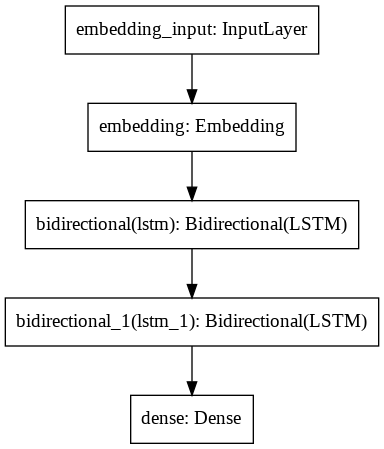

In [25]:
tf.keras.utils.plot_model(Emodel, '/content/drive/MyDrive/Colab Notebooks/Projects/ImagesEmotionR.png')

In [26]:
lab_ind_train

array([0, 0, 4, ..., 3, 4, 0])

In [27]:
history = Emodel.fit( 
    train_padded,
    lab_ind_train,
    validation_data= (val_padded, lab_ind_val),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 27s 43ms/step - loss: 1.3502 - accuracy: 0.4618 - val_loss: 0.8747 - val_accuracy: 0.6670
Epoch 2/20
500/500 [==============================] - 20s 41ms/step - loss: 0.6224 - accuracy: 0.7544 - val_loss: 0.6023 - val_accuracy: 0.7705
Epoch 3/20
500/500 [==============================] - 20s 41ms/step - loss: 0.3521 - accuracy: 0.8801 - val_loss: 0.5000 - val_accuracy: 0.8540
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2407 - accuracy: 0.9239 - val_loss: 0.4633 - val_accuracy: 0.8675
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.1629 - accuracy: 0.9477 - val_loss: 0.5275 - val_accuracy: 0.8325
Epoch 6/20
500/500 [==============================] - 20s 41ms/step - loss: 0.1276 - accuracy: 0.9609 - val_loss: 0.4303 - val_accuracy: 0.8780
Epoch 7/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1082 - accuracy: 0.9662 - val_loss: 0.3730 - val_accuracy:

In [ ]:
history.history

In [29]:
def show_history(history):
  epochs = len(history.history['accuracy'])
  plt.figure(figsize=(16, 6))

  plt.subplot(1, 2, 1)
  plt.plot(range(0, epochs), history.history['accuracy'], label= 'Training')
  plt.plot(range(0, epochs), history.history['val_accuracy'], label= 'Validation')
  plt.ylim(0.0, 1.0)
  plt.title('Accuracy during training')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(0, epochs), history.history['loss'], label= 'Training')
  plt.plot(range(0, epochs), history.history['val_loss'], label= 'Validation')
  plt.title('Loss during training')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

def plot_confusion_matrix(y_true, y_pred):
  from sklearn.metrics import confusion_matrix

  cmatrix = confusion_matrix(y_true, y_pred, normalize='true')

  plt.figure(figsize=(10, 10))
  subp = plt.subplot(1, 1, 1)
  cmat = subp.matshow(cmatrix)
  plt.xticks(list(range(0, 6)), labels= list(classes))
  plt.yticks(list(range(0, 6)), labels= list(classes))
  plt.colorbar(cmat)
  plt.show()

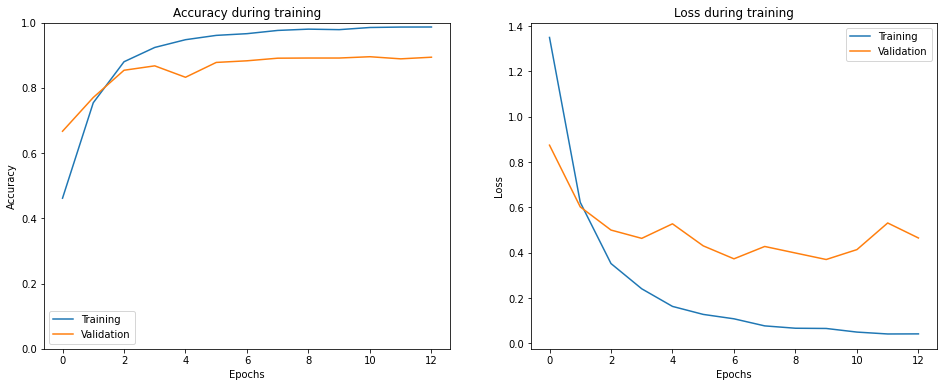

In [30]:
show_history(history)

### Evaluating the model

In [31]:
h_ev = Emodel.evaluate(test_padded, lab_ind_test)
print('Accuracy: {}'.format(h_ev[1]))

63/63 [==============================] - 1s 12ms/step - loss: 0.4937 - accuracy: 0.8895
Accuracy: 0.8895000219345093


Testing 10 random examples

In [34]:
import random

for i in range(10):
  rnumber = random.randint(0, len(lab_ind_test) - 1)
  print('Example {}'.format(rnumber))

  print('Tweet: {}'.format(tweets_test[rnumber]))
  print('Emotion: {}'.format(index_to_classes[lab_ind_test[rnumber]]))

  p = Emodel.predict(np.expand_dims(test_padded[rnumber], axis = 0))[0]
  predicted_class_t = index_to_classes[np.argmax(p).astype('uint8')]

  print('Predicted Emotion: {}\n'.format(predicted_class_t))

Example 1841
Tweet: i always end up feeling unwelcome and sad
Emotion: sadness
Predicted Emotion: sadness

Example 491
Tweet: i grew up feeling rejected by my male peers
Emotion: sadness
Predicted Emotion: sadness

Example 526
Tweet: i have tried sorting out the area for the cat houses this lunchtime but i guess after the printer ordeal i am feeling quite uptight so it has been put on hold
Emotion: fear
Predicted Emotion: fear

Example 73
Tweet: i can feel that they are kind friendly and can understand my feelings
Emotion: joy
Predicted Emotion: joy

Example 1954
Tweet: i just feel so hopeless sometimes
Emotion: sadness
Predicted Emotion: sadness

Example 1409
Tweet: im feeling very doubtful about the necessity of that big coat
Emotion: fear
Predicted Emotion: fear

Example 909
Tweet: i feel love se inscrie intr un rafinament lejer romantic si extrem de feminin
Emotion: love
Predicted Emotion: love

Example 1765
Tweet: i have been learning and re learning the lesson that no matter how 

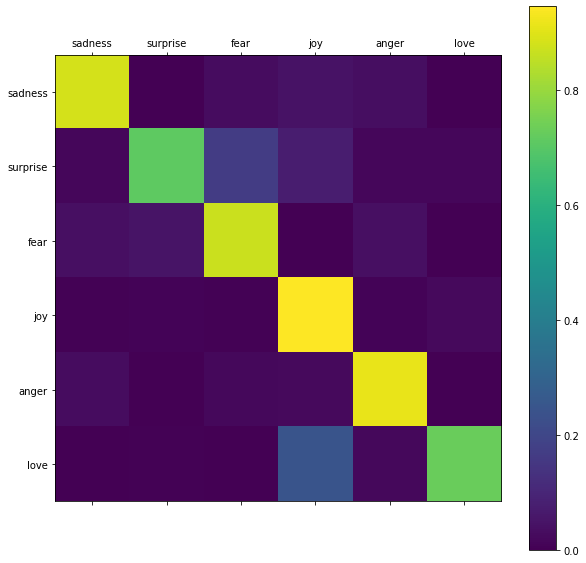

In [33]:
predicts = np.argmax(Emodel.predict(test_padded), axis=-1)
plot_confusion_matrix(lab_ind_test, predicts)

In [39]:
Emodel.save('/content/drive/MyDrive/Colab Notebooks/Projects/ImagesEmotionR/ERmodel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Projects/ImagesEmotionR/ERmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Projects/ImagesEmotionR/ERmodel/assets


In [38]:
Emodel.save('/content/drive/MyDrive/Colab Notebooks/Projects/ImagesEmotionR/Emotionmodel.h5')